# Wookiee Neighbors

Coding kNN from scratch to save your rebel alliance team!

Before diving into the train, test, and hold out sets, let's see what happens on some simplified data. Note that each wookiee planet/ship (row in our data) comes with x-, y-, and z-coordinates as well as a target label: chartreuse, white, blue, or red.  That said, let's create four sample planets to begin our analysis.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = [[10,  10,  10],
           [ 0,   0,   0],
           [-1,  -1,  -1],
           [ 1,   1,   1]]

y_train = ['chartreuse',
           'white',
           'blue',
           'red']

X_test = [[1.1, 1.1, 1.1]]  #Clearly this set of test coordinates is 
                            #  closest to the fourth training observation (red)

def distance(A, B):
    '''Computes Euclidean distance between two points, A and B.  
       Note this function works for any number of numeric features.'''
    squares = [(a - b) ** 2 for a, b in zip(A, B)]
    return sum(squares) ** 0.5

### Implementing 1-NN with a list comprehension

Note: the [enumerate function](http://book.pythontips.com/en/latest/enumerate.html) allows us to loop over an item and have an automatic counter.

In [3]:
def oneNN(X_train, y_train, X_test):
    
    result = []
    
    #Cycle through each test point
    for test in X_test:
        point, index = min([(distance(test,p), i) 
                                for i, p in enumerate(X_train)])
        result.append(y_train[index])  #Grab the target color label 
                                       # for the closest planet by 
                                       # referencing its index
    return result

In [4]:
for result in oneNN(X_train, y_train, X_test):
    print(result)

red


### To expand to k-NN, just get the closest k elements and choose most common class

Note: Below we use the function [most_common](https://docs.python.org/2/library/collections.html#collections.Counter.most_common), which comes for free when we use the Counter object.  The Counter objects just tallies up the number of times we see each class for us.

In [5]:
from collections import Counter

def KNN(X_train, y_train, X_test, k=1):
    result = []
    
    #Still cycle through each test point
    for test in X_test:
        
        #Same list comprehension from 1-NN, but instead of using min, sort and select first k elements
        s = sorted([(distance(test,p),i) for i,p in enumerate(X_train)])[:k] 
        
        #Select most common class via counter object, which returns a list of tuples, ex: [('red', 4)]
        c = Counter([y_train[i] for j,i in s]).most_common()
        result.append(c[0][0])  #Append the result for each test point
        
    return result

In [6]:
Counter(['blue', 'red', 'red', 'white', 'blue']).most_common()

[('blue', 2), ('red', 2), ('white', 1)]

In [7]:
r = Counter(['blue', 'red', 'red', 'white', 'blue']).most_common()
r 

[('blue', 2), ('red', 2), ('white', 1)]

In [8]:
for result in KNN(X_train, y_train, X_test, k=3):
    print(result)

red


## Train, Test, and Holdout Wookiees

Now let's see how our functions do on the train, test, and holdout datasets.

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [10]:
train = pd.read_csv('../data/wookiee-train.csv', index_col=0)
test = pd.read_csv('../data/wookiee-test.csv', index_col=0)
holdout = pd.read_csv('../data/wookiee-ho.csv', index_col=0)

In [11]:
train.head()

,wookieecolor,xcoord,ycoord,zcoord
0,red,-3.410692,0.854400,0.228154
1,red,0.350080,-0.751120,-1.845183
2,chartreuse,0.841712,-0.058204,0.246217
3,red,-0.646260,-1.821082,0.444616
4,blue,1.423538,2.269409,-1.061053


In [12]:
X_train = np.array(train.iloc[:, 1:])
y_train = train['wookieecolor']

X_test = np.array(test.iloc[:, 1:])
y_test = test['wookieecolor']

X_holdout = np.array(holdout)

#### One-NN predictions for test set

In [13]:
oneNN_test_pred = oneNN(X_train, y_train, X_test)

In [14]:
oneNN_test_pred[:10]

['chartreuse',
 'red',
 'red',
 'blue',
 'red',
 'white',
 'white',
 'red',
 'blue',
 'red']

In [15]:
accuracy_score(y_test, oneNN_test_pred)

0.688

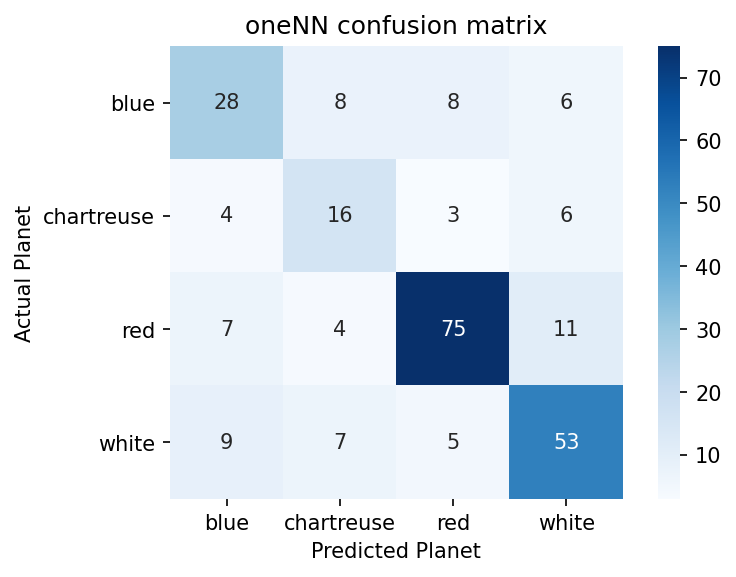

In [16]:
onenn_confusion = confusion_matrix(y_test, oneNN_test_pred)
plt.figure(dpi=150)
sns.heatmap(onenn_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['blue', 'chartreuse', 'red', 'white'],
           yticklabels=['blue', 'chartreuse', 'red', 'white'])
plt.xlabel('Predicted Planet')
plt.ylabel('Actual Planet')
plt.title('oneNN confusion matrix')
plt.yticks(rotation=0);

#### 5-NN predictions for test set

In [17]:
fiveNN_test_pred = KNN(X_train, y_train, X_test, k=5)

In [18]:
accuracy_score(y_test, fiveNN_test_pred)

0.744

In [19]:
print(classification_report(y_test, fiveNN_test_pred))

              precision    recall  f1-score   support

        blue       0.81      0.60      0.69        50
  chartreuse       0.65      0.45      0.53        29
         red       0.78      0.85      0.81        97
       white       0.69      0.82      0.75        74

    accuracy                           0.74       250
   macro avg       0.73      0.68      0.70       250
weighted avg       0.75      0.74      0.74       250



## Predictions for Holdout Set

In [20]:
fiveNN_holdout_pred = KNN(X_train, y_train, X_holdout, k=5)

In [21]:
fiveNN_holdout_pred[:15]

['red',
 'blue',
 'blue',
 'red',
 'white',
 'white',
 'blue',
 'red',
 'red',
 'red',
 'white',
 'blue',
 'red',
 'red',
 'blue']

#### Roughly check distributions of train/holdout

In [22]:
pd.Series(fiveNN_holdout_pred).value_counts(normalize=True)

red           0.453
white         0.326
blue          0.154
chartreuse    0.067
dtype: float64

In [23]:
y_train.value_counts(normalize=True)

red           0.389333
white         0.296000
blue          0.201333
chartreuse    0.113333
Name: wookieecolor, dtype: float64

#### Plot results

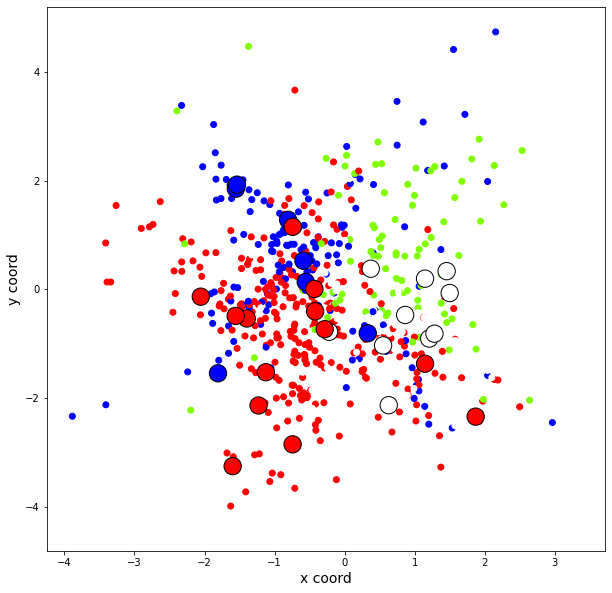

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(train.xcoord, train.ycoord, c=train.wookieecolor)
ax.scatter(holdout.xcoord[:30], holdout.ycoord[:30], 
            s=300, c=fiveNN_holdout_pred[:30], edgecolor='black')
plt.xlabel('x coord', fontsize=14)
plt.ylabel('y coord', fontsize=14);

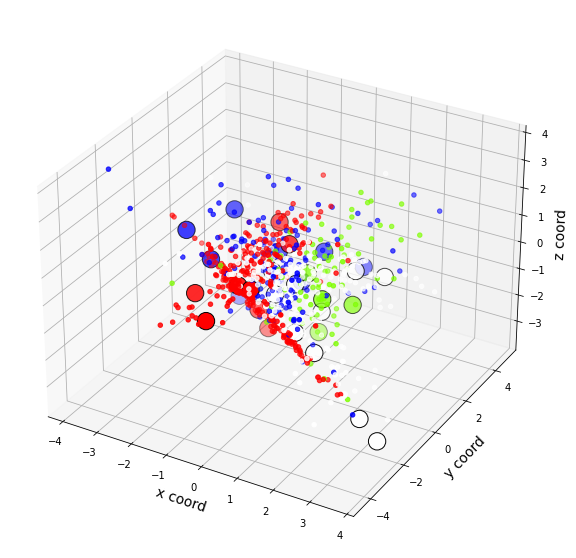

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train.xcoord, train.ycoord, train.zcoord, c=train.wookieecolor)
ax.scatter(holdout.xcoord[-30:], holdout.ycoord[-30:], holdout.zcoord[-30:], 
            s=300, c=fiveNN_holdout_pred[-30:], edgecolor='black')
ax.set_xlabel('x coord', fontsize=14)
ax.set_ylabel('y coord', fontsize=14)
ax.set_zlabel('z coord', fontsize=14)
plt.show()